In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset, JHUDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
Dataset = JHUDataset()

def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),  
        'population': Dataset.get_population_by_country_state(country, state),
    }
    
    MODEL_PARAMETERS = {        
        'model': 'seir',

        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        'presymptomatic_period': 3, # Time before exposed are infectious, In days
        'duration_mild_infections': 6, # Time mildly infected people stay sick before hospitalization or recovery, In days
        'hospital_time_recovery': 6, #Duration of hospitalization before icu or recovery, In days
        'icu_time_death': 8, #Time from ICU admission to death, In days

        'beta': 0.6,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,
        
        'hospitalization_rate': 0.0727,
        'hospitalized_cases_requiring_icu_care': 0.1397,
        'case_fatality_rate': .0109341104294479,
        
        'exposed_from_infected': True,

        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
    }
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)
             
INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 5, 18): None
    },   
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): None

    },
    {
        datetime.date(2020, 3, 3): 5,
    },
]

In [11]:
#JHUDataset.get_timeseries_by_country_state('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#Dataset.get_beds_by_country_state('USA', 'NY')

In [12]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [13]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40873 entries, 0 to 40872
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      40873 non-null  int64         
 1   date       40873 non-null  datetime64[ns]
 2   country    40873 non-null  object        
 3   state      35917 non-null  object        
 4   county     31651 non-null  object        
 5   cases      40854 non-null  float64       
 6   deaths     40432 non-null  float64       
 7   recovered  40485 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 2.5+ MB
{"beta": [0, 2.06925942343328e-08, 3.4487657057221337e-09, 3.4487657057221337e-09], "alpha": 0.3333333333333333, "gamma": [0, 0.15455, 0.0843, -0.010942242112556844], "rho": [0, 0.012116666666666664, 0.006609090909090909], "mu": 0.1537993849696997}
3.683669703


first case
2020-03-03 00:00:00
peak in hospitalizations
2020-05-16T00:00:00.000000000
avg doubling time by month
       doubling_time
month               
3               0.00
4               3.76
5             -52.88
6              -9.51
7              -8.28
8              -8.10
9              -8.07
10             -8.06
11             -8.06
12             -8.06
avg doubling time by week
      doubling_time
week               
10              nan
11              nan
12              nan
13              nan
14             4.80
15             3.46
16             3.13
17             3.27
18             4.04
19             7.43
20          -189.56
21           -39.73
22           -14.23
23           -10.92
24            -9.66
25            -9.04
26            -8.69
27            -8.48
28            -8.34
29            -8.25
30            -8.19
31            -8.15
32            -8.12
33            -8.10
34            -8.09
35            -8.08
36            -8.07
37            -8.07
38       

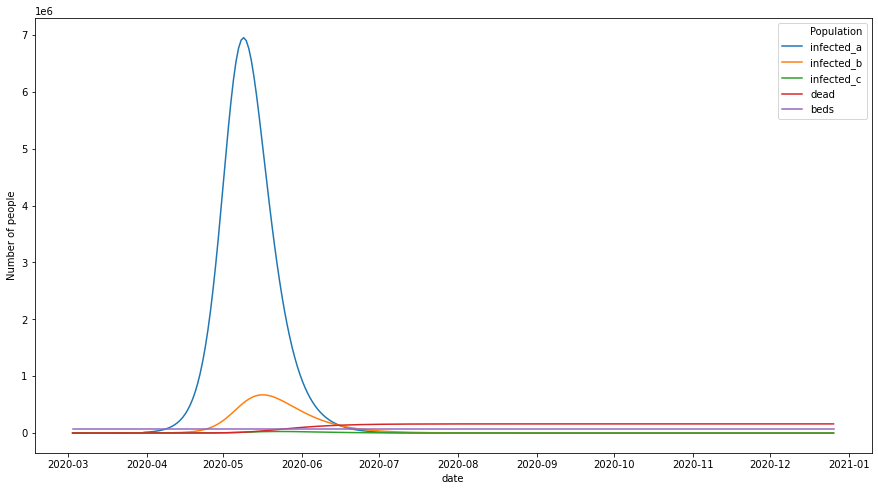

In [14]:
first_case_date = df.loc[(df.infected > 0), 'date'].min()
peak_date = df.loc[(df.infected_b == df.infected_b.max())]['date'].values[0]

print('first case')
print(first_case_date)
print('peak in hospitalizations')
print(peak_date)

df['month'] = pd.DatetimeIndex(df['date']).month
avg_doubling_month = df.loc[:, ('month', 'doubling_time')].groupby('month').mean()

print('avg doubling time by month')
print(avg_doubling_month)

df['week'] = pd.DatetimeIndex(df['date']).week
avg_doubling_month = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(df, chart_cols)

In [9]:
# df.head(25)

In [12]:
[intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

1.3000104512188007


first case
2020-03-03 00:00:00
peak in hospitalizations
2020-07-30T00:00:00.000000000
avg doubling time by month
       doubling_time
month               
3            -147.53
4             -17.43
5             -31.57
6               3.94
7              22.64
8             -17.78
9              -8.90
10             -8.35
11             -8.22
12             -8.19
avg doubling time by week
      doubling_time
week               
10              nan
11              nan
12              nan
13             6.58
14          -143.42
15            -9.77
16           -20.13
17           -14.17
18           -43.08
19          -100.35
20           -21.86
21            -2.91
22             7.61
23             4.23
24             3.86
25             3.82
26             3.86
27             4.04
28             4.62
29             6.58
30            15.21
31            53.45
32           -24.46
33           -14.05
34           -11.29
35           -10.08
36            -9.42
37            -9.03
38       

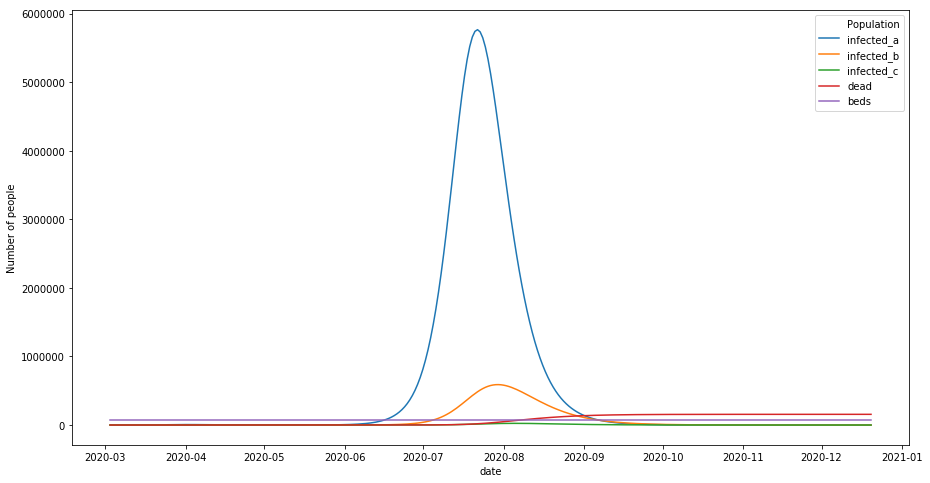

In [13]:
first_case_date = intervention_df.loc[(intervention_df.infected > 0), 'date'].min()
peak_date = intervention_df.loc[(intervention_df.infected_b == intervention_df.infected_b.max())]['date'].values[0]

print('first case')
print(first_case_date)
print('peak in hospitalizations')
print(peak_date)

intervention_df['month'] = pd.DatetimeIndex(intervention_df['date']).month
avg_doubling_month = intervention_df.loc[:, ('month', 'doubling_time')].groupby('month').mean()

print('avg doubling time by month')
print(avg_doubling_month)

intervention_df['week'] = pd.DatetimeIndex(intervention_df['date']).week
avg_doubling_month = intervention_df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(intervention_df, chart_cols)